In [163]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv, RGCNConv, Linear
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pykeen.triples import TriplesFactory


In [164]:
from owlready2 import get_ontology
import pandas as pd

# Step 1: Load the ontology
ontology_path = "enriched_ppio_ontology_final_54_small.owl"  # Replace with your OWL file path
ontology = get_ontology(ontology_path).load()

# Step 2: Extract triples for patients with disease statuses and their relationships
def extract_patient_triples(ontology, target_statuses, relations_of_interest):
    """
    Extract triples (subject, predicate, object) for patients with specific disease statuses
    and related properties like hasSample, isAssociatedWithPathway, hasGeneExpression.
    """
    triples = []

    # Iterate through all individuals in the ontology
    for patient in ontology.individuals():
        if "Patient" in [cls.name for cls in patient.is_a]:  # Filter only Patient instances
            disease_status = None
            samples = []

            # Extract properties of the patient
            for prop in patient.get_properties():
                for value in prop[patient]:
                    if prop.python_name == "hasDiseaseStatus":
                        disease_status = value
                    elif prop.python_name == "hasSample":
                        samples.append(value.name)

            # If the patient matches the target disease status
            if disease_status in target_statuses:
                triples.append((patient.name, "hasDiseaseStatus", disease_status))

                # Extract relationships for associated samples
                for sample_name in samples:
                    triples.append((patient.name, "hasSample", sample_name))
                    # Find relationships for the sample
                    for sample in ontology.individuals():
                        if sample.name == sample_name:
                            for prop in sample.get_properties():
                                if prop.python_name in relations_of_interest:
                                    for value in prop[sample]:
                                        if hasattr(value, 'name'):
                                            triples.append((sample.name, prop.python_name, value.name))

    return triples

# Step 3: Define disease statuses and relationships of interest
target_statuses = ["sepsis survivor", "sepsis non-survivor"]
relations_of_interest = ["isAssociatedWithPathway", "hasGeneExpression"]

# Step 4: Extract triples
triples = extract_patient_triples(ontology, target_statuses, relations_of_interest)

# Step 5: Convert to DataFrame and remove duplicates
triples_df1 = pd.DataFrame(triples, columns=["Subject", "Predicate", "Object"]).drop_duplicates()

# Step 6: Display the results
print("\n### Final Triples DataFrame ###")
print(triples_df1.head(20))



### Final Triples DataFrame ###
              Subject          Predicate             Object
0        Patient_S_29   hasDiseaseStatus    sepsis survivor
1        Patient_S_29          hasSample  Sample_GSM1317945
2   Sample_GSM1317945  hasGeneExpression         Gene_60496
3   Sample_GSM1317945  hasGeneExpression            Gene_18
4   Sample_GSM1317945  hasGeneExpression         Gene_10347
5   Sample_GSM1317945  hasGeneExpression           Gene_215
6   Sample_GSM1317945  hasGeneExpression            Gene_23
7   Sample_GSM1317945  hasGeneExpression            Gene_26
8   Sample_GSM1317945  hasGeneExpression         Gene_27034
9   Sample_GSM1317945  hasGeneExpression            Gene_37
10  Sample_GSM1317945  hasGeneExpression         Gene_91452
11  Sample_GSM1317945  hasGeneExpression         Gene_22985
12  Sample_GSM1317945  hasGeneExpression            Gene_51
13  Sample_GSM1317945  hasGeneExpression          Gene_2180
14  Sample_GSM1317945  hasGeneExpression         Gene_84532
15  Sam

In [88]:
triples_df1[triples_df1['Predicate']=='isAssociatedWithPathway']

,Subject,Predicate,Object


In [89]:

# Step 2: Extract relevant triples
def extract_gene_triples(ontology, relations_of_interest):
    """
    Extract triples (subject, predicate, object) for genes with specific relationships.
    """
    triples = []

    # Iterate through individuals in the ontology
    for entity in ontology.individuals():
        # Process only Gene entities
        if "Gene" in [cls.name for cls in entity.is_a]:
            for prop in entity.get_properties():
                # Match properties of interest
                if prop.python_name in relations_of_interest:
                    for value in prop[entity]:
                        if hasattr(value, 'name'):  # Check if value is another entity
                            triples.append((entity.name, prop.python_name, value.name))
    return triples

# Step 3: Define relationships of interest
relations_of_interest = [
 "isAssociatedWithPathway"
]

# Step 4: Extract triples
gene_triples = extract_gene_triples(ontology, relations_of_interest)

# Step 5: Convert to DataFrame
triples_df2 = pd.DataFrame(gene_triples, columns=["Subject", "Predicate", "Object"])

# Step 6: Display the triples
print("\n### Extracted Gene Triples ###")
print(triples_df2.head(20))  # Display the first 20 rows




### Extracted Gene Triples ###
       Subject                Predicate                 Object
0   Gene_60496  isAssociatedWithPathway        Pathway_0000000
1   Gene_60496  isAssociatedWithPathway  Pathway_R-HSA-1430728
2   Gene_60496  isAssociatedWithPathway   Pathway_R-HSA-196849
3   Gene_60496  isAssociatedWithPathway   Pathway_R-HSA-196854
4      Gene_18  isAssociatedWithPathway        Pathway_0000000
5      Gene_18  isAssociatedWithPathway   Pathway_R-HSA-112315
6      Gene_18  isAssociatedWithPathway   Pathway_R-HSA-112316
7   Gene_10347  isAssociatedWithPathway        Pathway_0000000
8   Gene_10347  isAssociatedWithPathway   Pathway_R-HSA-382551
9     Gene_215  isAssociatedWithPathway        Pathway_0000000
10    Gene_215  isAssociatedWithPathway  Pathway_R-HSA-1643685
11    Gene_215  isAssociatedWithPathway  Pathway_R-HSA-1430728
12    Gene_215  isAssociatedWithPathway   Pathway_R-HSA-556833
13    Gene_215  isAssociatedWithPathway   Pathway_R-HSA-382551
14    Gene_215  isAssoc

In [165]:
print(triples_df2.tail(20))  # Display the first 20 rows


          Subject                Predicate                Object
9162   Gene_25799  isAssociatedWithPathway       Pathway_0000000
9163   Gene_25799  isAssociatedWithPathway   Pathway_R-HSA-74160
9164   Gene_25799  isAssociatedWithPathway   Pathway_R-HSA-73857
9165   Gene_25799  isAssociatedWithPathway  Pathway_R-HSA-212436
9166  Gene_284443  isAssociatedWithPathway       Pathway_0000000
9167  Gene_284443  isAssociatedWithPathway   Pathway_R-HSA-74160
9168  Gene_284443  isAssociatedWithPathway   Pathway_R-HSA-73857
9169  Gene_284443  isAssociatedWithPathway  Pathway_R-HSA-212436
9170   Gene_51385  isAssociatedWithPathway       Pathway_0000000
9171   Gene_51385  isAssociatedWithPathway   Pathway_R-HSA-74160
9172   Gene_51385  isAssociatedWithPathway   Pathway_R-HSA-73857
9173   Gene_51385  isAssociatedWithPathway  Pathway_R-HSA-212436
9174  Gene_170960  isAssociatedWithPathway       Pathway_0000000
9175  Gene_170960  isAssociatedWithPathway   Pathway_R-HSA-74160
9176  Gene_170960  isAsso

In [166]:
triples_df1.shape

(135674, 3)

In [167]:
triples_df2.shape

(9182, 3)

In [168]:
# Step 1: Concatenate the two DataFrames
combined_df = pd.concat([triples_df1, triples_df2], ignore_index=True)

# Step 2: Display the combined DataFrame
print("\n### Combined Triples DataFrame ###")
print(combined_df)


### Combined Triples DataFrame ###
                  Subject                Predicate                Object
0            Patient_S_29         hasDiseaseStatus       sepsis survivor
1            Patient_S_29                hasSample     Sample_GSM1317945
2       Sample_GSM1317945        hasGeneExpression            Gene_60496
3       Sample_GSM1317945        hasGeneExpression               Gene_18
4       Sample_GSM1317945        hasGeneExpression            Gene_10347
...                   ...                      ...                   ...
144851        Gene_170960  isAssociatedWithPathway  Pathway_R-HSA-212436
144852        Gene_155061  isAssociatedWithPathway       Pathway_0000000
144853        Gene_155061  isAssociatedWithPathway   Pathway_R-HSA-74160
144854        Gene_155061  isAssociatedWithPathway   Pathway_R-HSA-73857
144855        Gene_155061  isAssociatedWithPathway  Pathway_R-HSA-212436

[144856 rows x 3 columns]


In [169]:
from pykeen.triples import TriplesFactory
import numpy as np

# Convert DataFrame to numpy array
triples_array = combined_df.to_numpy()

# Step 1: Create a complete triples factory
complete_factory = TriplesFactory.from_labeled_triples(triples_array)

# Step 2: Split the data consistently
training_factory, validation_factory, testing_factory = complete_factory.split(
    ratios=[0.7, 0.15, 0.15], random_state=42
)

# Step 3: Check the splits
print("Number of training triples:", train_factory.num_triples)
print("Number of validation triples:", valid_factory.num_triples)
print("Number of test triples:", test_factory.num_triples)


INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [99469, 21728, 21729]


Number of training triples: 101399
Number of validation triples: 21728
Number of test triples: 21729


In [162]:
negative_sampler_config = {
    'negative_sampler': 'basic',  # 'basic' is a standard PyKEEN negative sampler
    'negative_sampler_kwargs': {'num_negs_per_pos': 10}  # Number of negative samples per positive triple
}


In [170]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from pykeen.pipeline import pipeline


# Step 2: Train TransE Model
transe_result = pipeline(
    model='TransE',
    training=training_factory,
    validation=validation_factory,
    testing=testing_factory,
    epochs=10,
    dimensions=128,
    random_seed=42,
    **negative_sampler_config  # Add negative sampling
)

# Step 3: Train ComplEx Model
complex_result = pipeline(
    model='ComplEx',
    training=training_factory,
    validation=validation_factory,
    testing=testing_factory,
    epochs=10,
    dimensions=128,
    random_seed=42,
    **negative_sampler_config  # Add negative sampling
)

# Step 4: Train RotatE Model
rotate_result = pipeline(
    model='RotatE',
    training=training_factory,
    validation=validation_factory,
    testing=testing_factory,
    epochs=10,
    dimensions=128,
    random_seed=42,
    **negative_sampler_config  # Add negative sampling
)



# Step 5: Extract Embeddings from Models
transE_embeddings = transe_result.model.entity_representations[0]().detach().cpu().numpy()
complEx_embeddings = np.concatenate(
    [complex_result.model.entity_representations[0]().real.detach().cpu().numpy(),
     complex_result.model.entity_representations[0]().imag.detach().cpu().numpy()],
    axis=1
)
rotate_embeddings = rotate_result.model.entity_representations[0]().detach().cpu().numpy()


INFO:pykeen.pipeline.api:Using device: None
Training batches on cpu:  86%|██████████████████▉   | 341/397 [00:00<00:00, 704.92batch/s]
Training epochs on cpu:  10%| | 1/10 [00:02<00:18,  2.04s/epoch, loss=0.635, prev_loss=nan
Training batches on cpu:  90%|███████████████████▊  | 357/397 [00:00<00:00, 703.14batch/s]
Training epochs on cpu:  20%|▏| 2/10 [00:04<00:17,  2.20s/epoch, loss=0.415, prev_loss=0.6
Training batches on cpu:  90%|███████████████████▉  | 359/397 [00:00<00:00, 727.46batch/s]
Training epochs on cpu:  30%|▎| 3/10 [00:06<00:14,  2.11s/epoch, loss=0.394, prev_loss=0.4
Training batches on cpu:  89%|███████████████████▌  | 353/397 [00:00<00:00, 712.13batch/s]
Training epochs on cpu:  40%|▍| 4/10 [00:08<00:12,  2.07s/epoch, loss=0.387, prev_loss=0.3
Training batches on cpu:  90%|███████████████████▉  | 359/397 [00:00<00:00, 722.67batch/s]
Training epochs on cpu:  50%|▌| 5/10 [00:10<00:10,  2.05s/epoch, loss=0.381, prev_loss=0.3
Training batches on cpu:  90%|████████████████

In [171]:
# Convert RotatE complex embeddings to real-valued embeddings
rotate_real_embeddings = np.concatenate(
    [rotate_embeddings.real, rotate_embeddings.imag], axis=1
    
)


In [175]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Prepare the graph data
# Define entity IDs
entities = {entity: idx for idx, entity in enumerate(training_factory.entity_to_id.keys())}

# Convert triples into edges for PyTorch Geometric
edge_index = torch.tensor([
    [entities[head], entities[tail]]
    for head, _, tail in training_factory.triples
]).t().contiguous()

# Create a graph
num_nodes = len(entities)
x = torch.randn(num_nodes, 128)  # Random initialization of node features
data = Data(x=x, edge_index=edge_index)

# Define GCN Model
class GCNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Train GCN
gcn_model = GCNModel(input_dim=128, hidden_dim=64, output_dim=128)
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01)
for epoch in range(50):
    optimizer.zero_grad()
    embeddings = gcn_model(data)
    loss = torch.nn.MSELoss()(embeddings, data.x)  # Reconstruction loss
    loss.backward()
    optimizer.step()

# Extract GCN embeddings
gcn_embeddings = embeddings.detach().cpu().numpy()


TransE Clustering Metrics:
Silhouette Score: 0.0200
Davies-Bouldin Index: 5.3015
Calinski-Harabasz Index: 46.3908



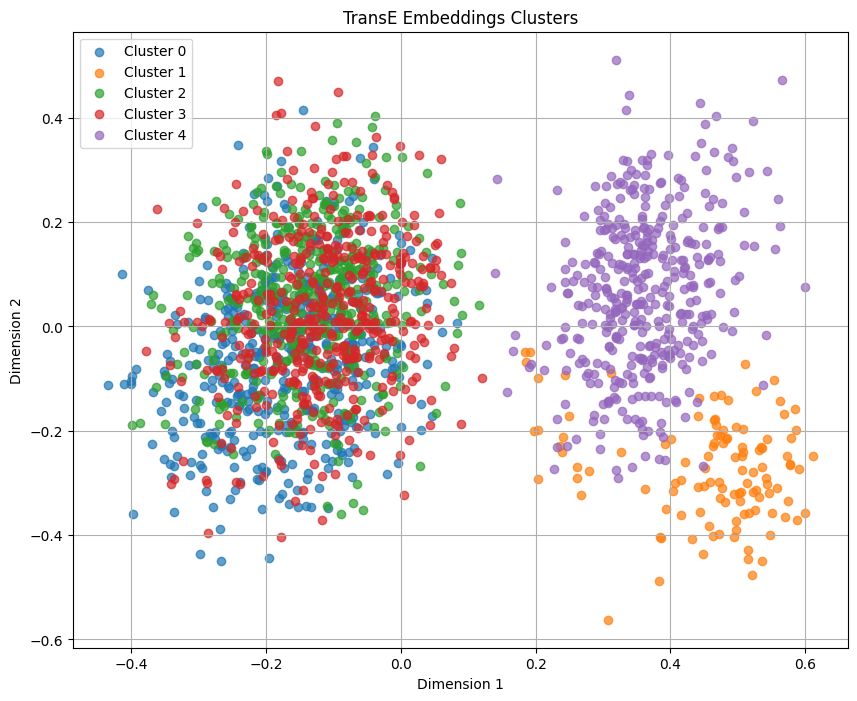

ComplEx Clustering Metrics:
Silhouette Score: 0.0014
Davies-Bouldin Index: 13.0232
Calinski-Harabasz Index: 4.2776



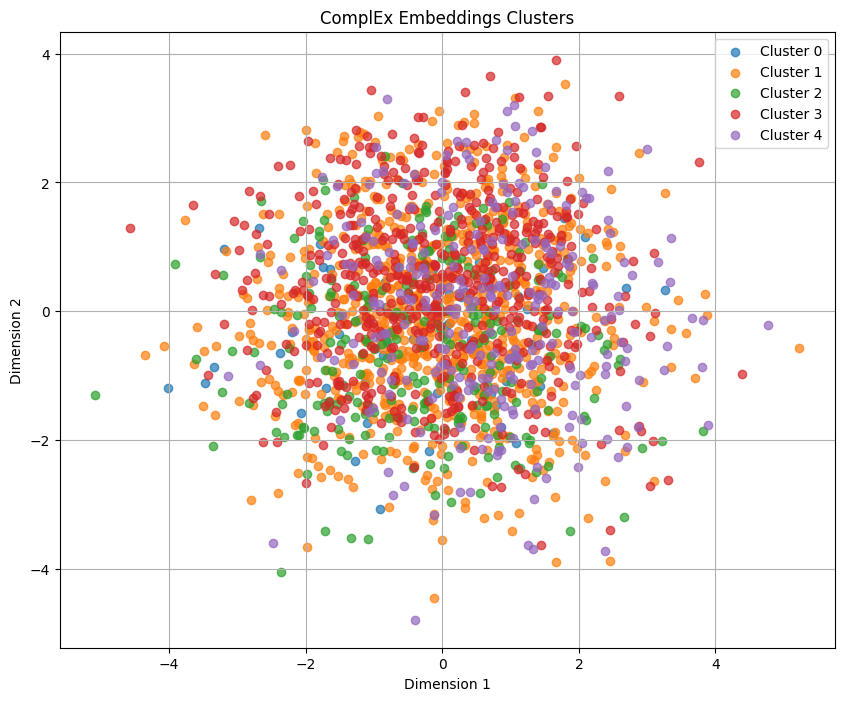

GCN Clustering Metrics:
Silhouette Score: 0.2248
Davies-Bouldin Index: 1.2594
Calinski-Harabasz Index: 455.3491



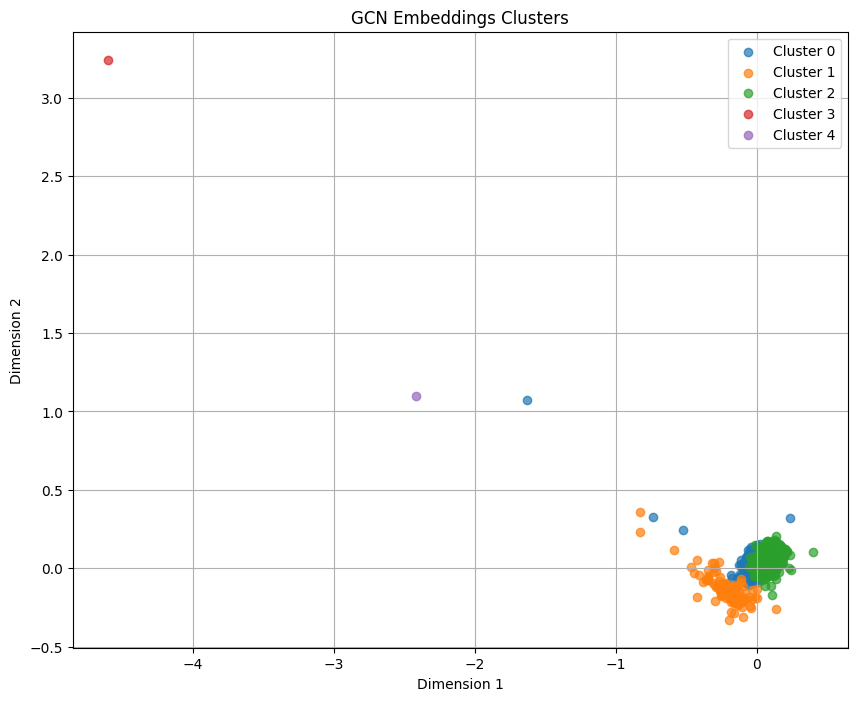

RotatE Clustering Metrics:
Silhouette Score: 0.0323
Davies-Bouldin Index: 3.2233
Calinski-Harabasz Index: 141.4077



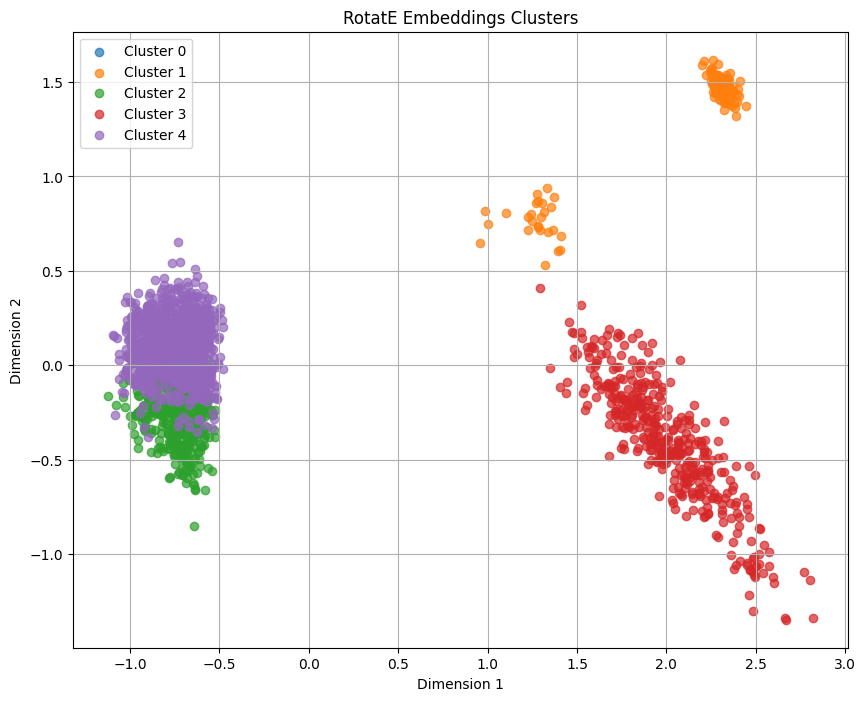


### Clustering Metrics Comparison ###
     Model  Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz Index
0   TransE          0.019993              5.301539                46.390800
1  ComplEx          0.001433             13.023206                 4.277605
2      GCN          0.224848              1.259365               455.349091
3   RotatE          0.032336              3.223339               141.407684


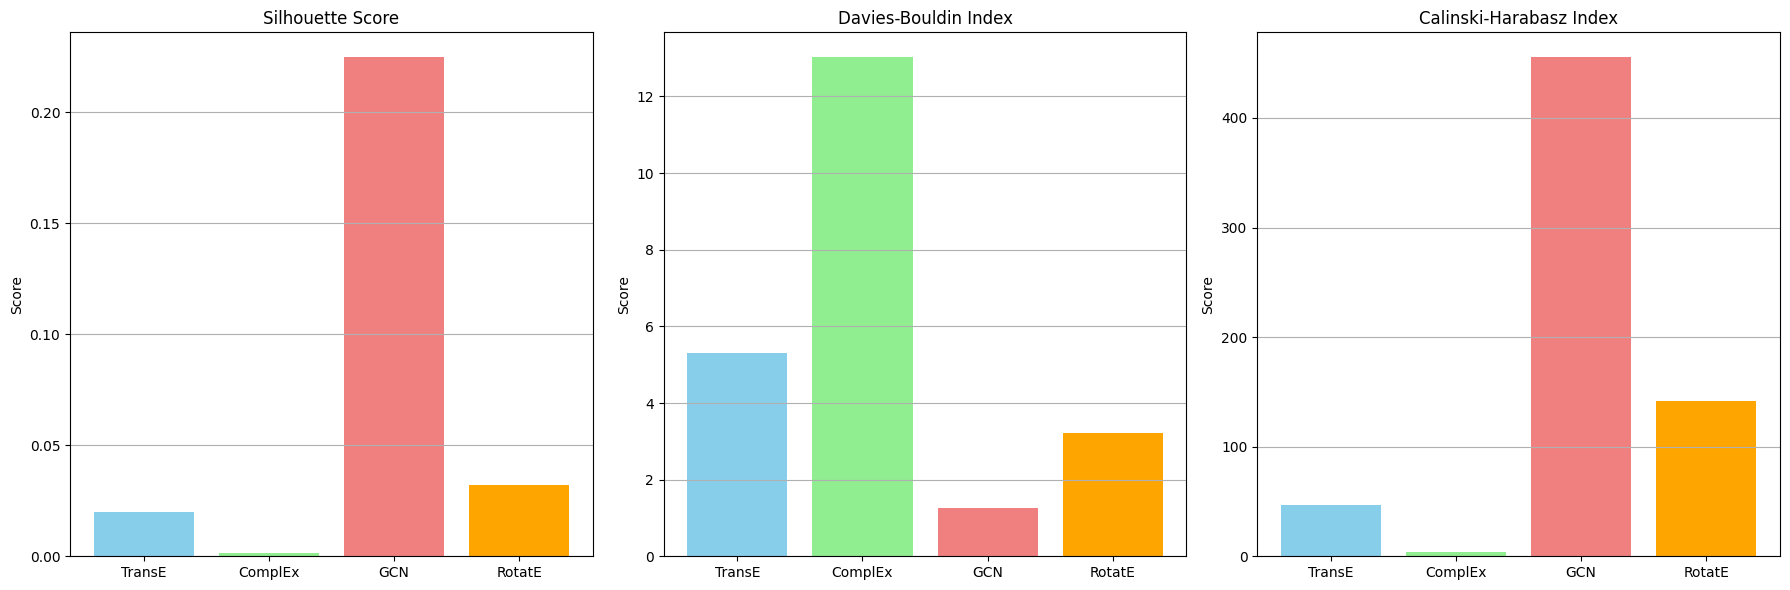

In [176]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Store results
clustering_results = []

def cluster_and_visualize(embeddings, model_name):
    # Clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)

    # Calculate Clustering Metrics
    silhouette = silhouette_score(embeddings, cluster_labels)
    db_index = davies_bouldin_score(embeddings, cluster_labels)
    ch_index = calinski_harabasz_score(embeddings, cluster_labels)

    # Store Results
    clustering_results.append({
        "Model": model_name,
        "Silhouette Score": silhouette,
        "Davies-Bouldin Index": db_index,
        "Calinski-Harabasz Index": ch_index
    })

    print(f"{model_name} Clustering Metrics:")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Index: {db_index:.4f}")
    print(f"Calinski-Harabasz Index: {ch_index:.4f}\n")

    # Dimensionality Reduction (PCA)
    reduced_embeddings = PCA(n_components=2).fit_transform(embeddings)

    # Visualization
    plt.figure(figsize=(10, 8))
    for cluster_id in np.unique(cluster_labels):
        cluster_points = reduced_embeddings[cluster_labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", alpha=0.7)
    plt.title(f"{model_name} Embeddings Clusters")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.grid()
    plt.show()

# Apply clustering and visualization for each embedding type
cluster_and_visualize(transE_embeddings, "TransE")
cluster_and_visualize(complEx_embeddings, "ComplEx")
cluster_and_visualize(gcn_embeddings, "GCN")
cluster_and_visualize(rotate_real_embeddings, "RotatE")

# Step 2: Summarize Clustering Results
results_df = pd.DataFrame(clustering_results)
print("\n### Clustering Metrics Comparison ###")
print(results_df)

# Step 3: Visualize Clustering Metrics
metrics = ["Silhouette Score", "Davies-Bouldin Index", "Calinski-Harabasz Index"]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, metric in enumerate(metrics):
    axes[i].bar(results_df["Model"], results_df[metric], color=["skyblue", "lightgreen", "lightcoral", "orange"])
    axes[i].set_title(metric)
    axes[i].set_ylabel("Score")
    axes[i].grid(axis="y")

plt.tight_layout()
plt.show()


## Clustering Results

## Link Prediction Results

In [173]:
# Function to extract evaluation metrics dynamically
def extract_metrics(pipeline_result):
    """
    Extract Mean Rank, MRR, Hits@1, Hits@3, Hits@10 dynamically from PyKEEN pipeline results.
    """
    metrics = pipeline_result.metric_results.to_dict()
    mean_rank = metrics["both"]["realistic"]["arithmetic_mean_rank"]
    mrr = metrics["both"]["realistic"]["inverse_harmonic_mean_rank"]
    hits_at_1 = metrics["both"]["realistic"]["hits_at_1"]
    hits_at_3 = metrics["both"]["realistic"]["hits_at_3"]
    hits_at_10 = metrics["both"]["realistic"]["hits_at_10"]
    return [mean_rank, mrr, hits_at_1, hits_at_3, hits_at_10]

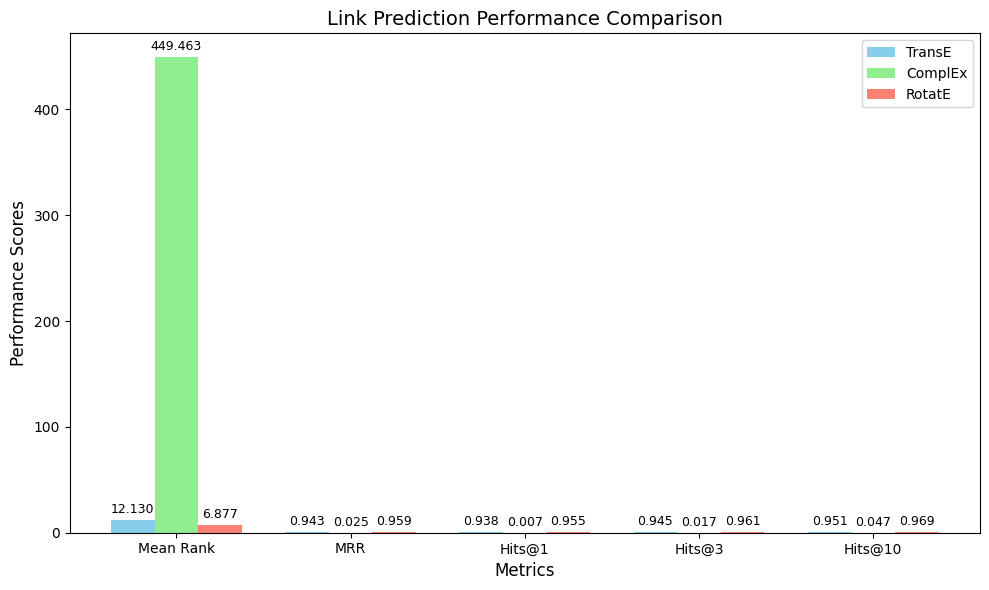


### Link Prediction Results ###
      Metric     TransE     ComplEx    RotatE
0  Mean Rank  12.130126  449.463440  6.877272
1        MRR   0.943112    0.024663  0.959396
2     Hits@1   0.938400    0.006604  0.954577
3     Hits@3   0.944590    0.017074  0.960652
4    Hits@10   0.950550    0.047080  0.968982


In [174]:
# Extract metrics dynamically
metrics = ["Mean Rank", "MRR", "Hits@1", "Hits@3", "Hits@10"]
transe_results = extract_metrics(transe_result)
complex_results = extract_metrics(complex_result)
rotate_results = extract_metrics(rotate_result)

# Visualization of Results
fig, ax = plt.subplots(figsize=(10, 6))

# Create bar width and x-axis positions
x = np.arange(len(metrics))
width = 0.25

# Plot bars for each model
bars1 = ax.bar(x - width, transe_results, width, label='TransE', color='skyblue')
bars2 = ax.bar(x, complex_results, width, label='ComplEx', color='lightgreen')
bars3 = ax.bar(x + width, rotate_results, width, label='RotatE', color='salmon')

# Labels and Title
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Performance Scores', fontsize=12)
ax.set_title('Link Prediction Performance Comparison', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=10)
ax.legend()

# Add value labels on top of bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',  # Format to 3 decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Add labels to each set of bars
add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

# Show the plot
plt.tight_layout()
plt.show()

# Display results in tabular format
data = {
    "Metric": metrics,
    "TransE": transe_results,
    "ComplEx": complex_results,
    "RotatE": rotate_results,
}
results_df = pd.DataFrame(data)
print("\n### Link Prediction Results ###")
print(results_df)

In [181]:
# import torch
# import numpy as np

# # Step 1: Scoring Function
# def score_triple(embeddings, h, t):
#     """
#     Calculate the distance score for a triple using a TransE-style scoring function.
#     Lower scores are better (closer embeddings).
#     """
#     h_emb = embeddings[h]
#     t_emb = embeddings[t]
#     return torch.norm(h_emb - t_emb, p=1)  # L1 distance (TransE style)

# # Step 2: Generate Negative Samples
# def generate_negative_samples(h, t, num_entities, corrupt_tail=True):
#     """
#     Generate negative samples for a single test triple by corrupting head or tail.
#     """
#     corrupted_triples = []
#     for idx in range(num_entities):
#         if corrupt_tail and idx != t:
#             corrupted_triples.append((h, idx))
#         elif not corrupt_tail and idx != h:
#             corrupted_triples.append((idx, t))
#     return corrupted_triples

# # Step 3: Evaluate on Test Set
# def evaluate_link_prediction(gcn_embeddings, test_triples, num_entities):
#     """
#     Evaluate GCN embeddings on link prediction tasks using the test set.
#     """
#     ranks = []
#     hits_at_1 = 0
#     hits_at_3 = 0
#     hits_at_10 = 0

#     for h, _, t in test_triples:  # Use test triples (h, r, t) with placeholder relation
#         # Positive triple score
#         positive_score = score_triple(gcn_embeddings, h, t)

#         # Generate negative samples (corrupt tail here)
#         negative_triples = generate_negative_samples(h, t, num_entities, corrupt_tail=True)
        
#         # Score all negative samples
#         negative_scores = [score_triple(gcn_embeddings, nh, nt) for nh, nt in negative_triples]

#         # Combine positive and negative scores
#         all_scores = torch.tensor([positive_score] + negative_scores)
        
#         # Rank the positive triple
#         rank = torch.argsort(all_scores).tolist().index(0) + 1  # Rank starts at 1
#         ranks.append(rank)

#         # Hits@k
#         if rank <= 1:
#             hits_at_1 += 1
#         if rank <= 3:
#             hits_at_3 += 1
#         if rank <= 10:
#             hits_at_10 += 1

#     # Compute final metrics
#     mean_rank = np.mean(ranks)
#     mrr = np.mean([1.0 / rank for rank in ranks])
#     hits_at_1 /= len(test_triples)
#     hits_at_3 /= len(test_triples)
#     hits_at_10 /= len(test_triples)

#     return mean_rank, mrr, hits_at_1, hits_at_3, hits_at_10

# # Step 4: Load Your Test Triples

# # Number of entities in the dataset
# num_entities = len(gcn_embeddings)

# # Step 5: Evaluate the GCN Embeddings
# gcn_embeddings = torch.tensor(gcn_embeddings, dtype=torch.float32)
# mean_rank, mrr, hits_at_1, hits_at_3, hits_at_10 = evaluate_link_prediction(
#     gcn_embeddings, testing_factory, num_entities
# )

# # Print Metrics
# print("Link Prediction Evaluation Results:")
# print(f"Mean Rank: {mean_rank:.2f}")
# print(f"MRR: {mrr:.4f}")
# print(f"Hits@1: {hits_at_1:.4f}")
# print(f"Hits@3: {hits_at_3:.4f}")
# print(f"Hits@10: {hits_at_10:.4f}")


## Standarization of Links


Extracted Data:
           Sample_ID      Gene_ID  Expression_Value
0  Sample_GSM1318058  Gene_140831          7.183538
1  Sample_GSM1318048    Gene_9274          7.183538
2  Sample_GSM1318046  Gene_221294          7.183538
3  Sample_GSM1318025  Gene_253725          7.183538
4  Sample_GSM1318011  Gene_641806          7.183538


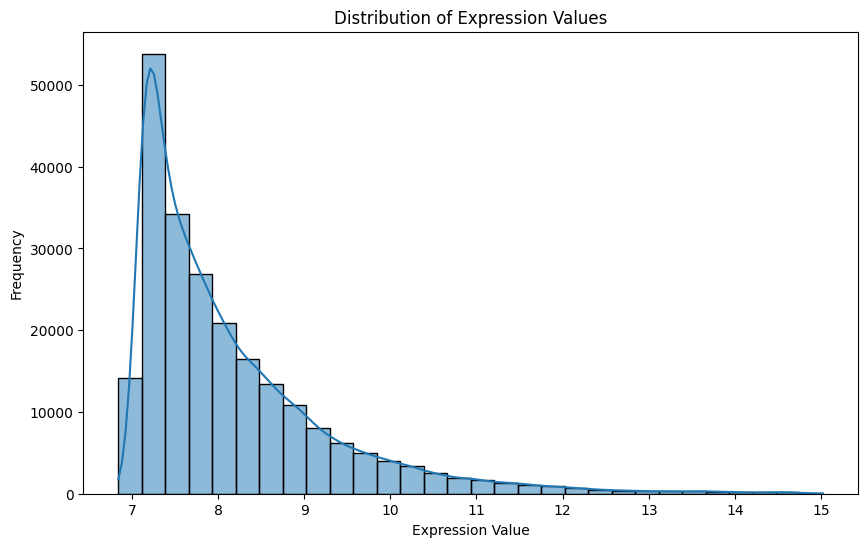

Low Threshold: 7.45
Medium Threshold: 8.24

Derived Relationships:
           Sample_ID Derived_Relationship      Gene_ID
0  Sample_GSM1318058     hasExpressionLow  Gene_140831
1  Sample_GSM1318048     hasExpressionLow    Gene_9274
2  Sample_GSM1318046     hasExpressionLow  Gene_221294
3  Sample_GSM1318025     hasExpressionLow  Gene_253725
4  Sample_GSM1318011     hasExpressionLow  Gene_641806

Categorized Expression Values:
           Sample_ID      Gene_ID  Expression_Value Derived_Relationship
0  Sample_GSM1318058  Gene_140831          7.183538     hasExpressionLow
1  Sample_GSM1318048    Gene_9274          7.183538     hasExpressionLow
2  Sample_GSM1318046  Gene_221294          7.183538     hasExpressionLow
3  Sample_GSM1318025  Gene_253725          7.183538     hasExpressionLow
4  Sample_GSM1318011  Gene_641806          7.183538     hasExpressionLow


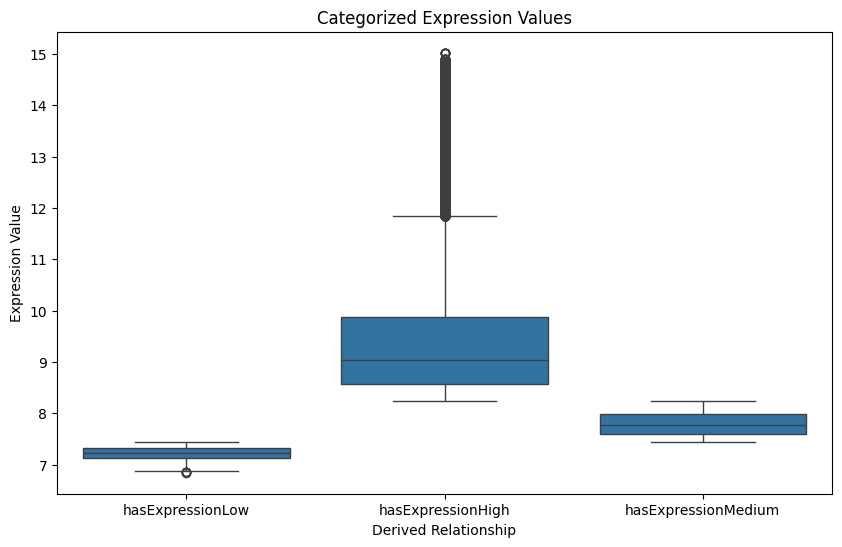

In [102]:
from rdflib import Graph, Namespace
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load the OWL file
owl_file_path = 'enriched_ppio_ontology_final_54_small.owl' 
g = Graph()
g.parse(owl_file_path, format='xml')

# Define namespaces
GO = Namespace("http://purl.obolibrary.org/obo/go.owl#")
OWL = Namespace("http://www.w3.org/2002/07/owl#")

# Initialize data storage
data = []

# Debugging: Iterate through RDF triples and handle blank nodes
for s in g.subjects(predicate=GO.hasExpressionValue, object=None):
    # Extract the expression value
    expression_value = None
    for p, o in g.predicate_objects(subject=s):
        if str(p) == str(GO.hasExpressionValue):
            try:
                expression_value = float(o)
            except ValueError:
                continue

        # Extract annotatedSource (Sample_ID)
        if "annotatedSource" in str(p):
            sample_id = o.split("#")[-1]

        # Extract annotatedTarget (Gene_ID)
        if "annotatedTarget" in str(p):
            gene_id = o.split("#")[-1]

    # Append data if all components exist
    if expression_value is not None and 'sample_id' in locals() and 'gene_id' in locals():
        data.append((sample_id, gene_id, expression_value))

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Sample_ID", "Gene_ID", "Expression_Value"])

# Debugging: Check extracted data
print("\nExtracted Data:")
print(df.head())

# Step 1: Visualize the distribution of Expression Values
plt.figure(figsize=(10, 6))
sns.histplot(df['Expression_Value'], bins=30, kde=True)
plt.title("Distribution of Expression Values")
plt.xlabel("Expression Value")
plt.ylabel("Frequency")
plt.show()

# Step 2: Calculate quantiles for categorization
low_threshold = df['Expression_Value'].quantile(0.33)  # Lower 33%
medium_threshold = df['Expression_Value'].quantile(0.66)  # Upper 66%

print(f"Low Threshold: {low_threshold:.2f}")
print(f"Medium Threshold: {medium_threshold:.2f}")

# Step 3: Update the categorization function
def categorize_expression(value):
    """Categorize expression value into Low, Medium, or High based on quantiles."""
    if value <= low_threshold:
        return "hasExpressionLow"
    elif low_threshold < value <= medium_threshold:
        return "hasExpressionMedium"
    else:
        return "hasExpressionHigh"

# Apply categorization
if not df.empty:
    df['Derived_Relationship'] = df['Expression_Value'].apply(categorize_expression)

    # Convert derived relationships to triples
    derived_triples = df[['Sample_ID', 'Derived_Relationship', 'Gene_ID']]
    print("\nDerived Relationships:")
    print(derived_triples.head())

else:
    print("No data found for derived relationships.")
    

# Step 5: Display categorized data
print("\nCategorized Expression Values:")
print(df[['Sample_ID', 'Gene_ID', 'Expression_Value', 'Derived_Relationship']].head())

# Step 6: Visualize the categorized data
plt.figure(figsize=(10, 6))
sns.boxplot(x="Derived_Relationship", y="Expression_Value", data=df)
plt.title("Categorized Expression Values")
plt.xlabel("Derived Relationship")
plt.ylabel("Expression Value")
plt.show()




In [105]:
derived_triples[derived_triples['Derived_Relationship']=='hasExpressionHigh']

,Sample_ID,Derived_Relationship,Gene_ID
8,Sample_GSM1318058,hasExpressionHigh,Gene_57169
9,Sample_GSM1318054,hasExpressionHigh,Gene_441743
10,Sample_GSM1318047,hasExpressionHigh,Gene_57045
11,Sample_GSM1318027,hasExpressionHigh,Gene_4830
12,Sample_GSM1318026,hasExpressionHigh,Gene_29956
...,...,...,...
229840,Sample_GSM1317911,hasExpressionHigh,Gene_2534
229856,Sample_GSM1317910,hasExpressionHigh,Gene_6670
230007,Sample_GSM1317904,hasExpressionHigh,Gene_11275
230081,Sample_GSM1317900,hasExpressionHigh,Gene_79188


In [106]:
from owlready2 import get_ontology
import pandas as pd

# Step 1: Load the ontology
ontology_path = "enriched_ppio_ontology_final_54_small.owl"  # Replace with your OWL file path
ontology = get_ontology(ontology_path).load()

# Step 2: Extract triples for patients with disease statuses and their relationships
def extract_patient_triples(ontology, target_statuses, relations_of_interest):
    """
    Extract triples (subject, predicate, object) for patients with specific disease statuses
    and related properties like hasSample, isAssociatedWithPathway, hasGeneExpression.
    """
    triples = []

    # Iterate through all individuals in the ontology
    for patient in ontology.individuals():
        if "Patient" in [cls.name for cls in patient.is_a]:  # Filter only Patient instances
            disease_status = None
            samples = []

            # Extract properties of the patient
            for prop in patient.get_properties():
                for value in prop[patient]:
                    if prop.python_name == "hasDiseaseStatus":
                        disease_status = value
                    elif prop.python_name == "hasSample":
                        samples.append(value.name)

            # If the patient matches the target disease status
            if disease_status in target_statuses:
                triples.append((patient.name, "hasDiseaseStatus", disease_status))

                # Extract relationships for associated samples
                for sample_name in samples:
                    triples.append((patient.name, "hasSample", sample_name))
                    # Find relationships for the sample
                    for sample in ontology.individuals():
                        if sample.name == sample_name:
                            for prop in sample.get_properties():
                                if prop.python_name in relations_of_interest:
                                    for value in prop[sample]:
                                        if hasattr(value, 'name'):
                                            triples.append((sample.name, prop.python_name, value.name))

    return triples

# Step 3: Define disease statuses and relationships of interest
target_statuses = ["sepsis survivor", "sepsis non-survivor"]
relations_of_interest = ["isAssociatedWithPathway"]

# Step 4: Extract triples
triples = extract_patient_triples(ontology, target_statuses, relations_of_interest)

# Step 5: Convert to DataFrame and remove duplicates
triples_df1 = pd.DataFrame(triples, columns=["Subject", "Predicate", "Object"]).drop_duplicates()

# Step 6: Display the results
print("\n### Final Triples DataFrame ###")
print(triples_df1.head(20))



### Final Triples DataFrame ###
         Subject         Predicate             Object
0   Patient_S_29  hasDiseaseStatus    sepsis survivor
1   Patient_S_29         hasSample  Sample_GSM1317945
2   Patient_S_30  hasDiseaseStatus    sepsis survivor
3   Patient_S_30         hasSample  Sample_GSM1317946
4   Patient_S_30         hasSample  Sample_GSM1317971
5   Patient_S_30         hasSample  Sample_GSM1317995
6   Patient_S_30         hasSample  Sample_GSM1318016
7   Patient_S_30         hasSample  Sample_GSM1318030
8   Patient_S_31  hasDiseaseStatus    sepsis survivor
9   Patient_S_31         hasSample  Sample_GSM1317947
10  Patient_S_31         hasSample  Sample_GSM1317972
11  Patient_S_31         hasSample  Sample_GSM1317996
12  Patient_S_32  hasDiseaseStatus    sepsis survivor
13  Patient_S_32         hasSample  Sample_GSM1317948
14  Patient_S_32         hasSample  Sample_GSM1317973
15  Patient_S_32         hasSample  Sample_GSM1317997
16  Patient_S_33  hasDiseaseStatus    sepsis surv

In [107]:
# Step 1: Concatenate the two DataFrames
combined_df = pd.concat([triples_df1, triples_df2], ignore_index=True)

# Step 2: Display the combined DataFrame
print("\n### Combined Triples DataFrame ###")
print(combined_df)


### Combined Triples DataFrame ###
           Subject                Predicate                Object
0     Patient_S_29         hasDiseaseStatus       sepsis survivor
1     Patient_S_29                hasSample     Sample_GSM1317945
2     Patient_S_30         hasDiseaseStatus       sepsis survivor
3     Patient_S_30                hasSample     Sample_GSM1317946
4     Patient_S_30                hasSample     Sample_GSM1317971
...            ...                      ...                   ...
9299   Gene_170960  isAssociatedWithPathway  Pathway_R-HSA-212436
9300   Gene_155061  isAssociatedWithPathway       Pathway_0000000
9301   Gene_155061  isAssociatedWithPathway   Pathway_R-HSA-74160
9302   Gene_155061  isAssociatedWithPathway   Pathway_R-HSA-73857
9303   Gene_155061  isAssociatedWithPathway  Pathway_R-HSA-212436

[9304 rows x 3 columns]


In [108]:
derived_triples_df = derived_triples.rename(columns={
    "Sample_ID": "Subject",
    "Derived_Relationship": "Predicate",
    "Gene_ID": "Object"
})

In [110]:
derived_triples_df.shape

(230156, 3)

In [111]:
derived_triples_df.head()

,Subject,Predicate,Object
0,Sample_GSM1318058,hasExpressionLow,Gene_140831
1,Sample_GSM1318048,hasExpressionLow,Gene_9274
2,Sample_GSM1318046,hasExpressionLow,Gene_221294
3,Sample_GSM1318025,hasExpressionLow,Gene_253725
4,Sample_GSM1318011,hasExpressionLow,Gene_641806


In [112]:
# Step 1: Concatenate the two DataFrames
combined_df_stand = pd.concat([combined_df, derived_triples_df], ignore_index=True)

# Step 2: Display the combined DataFrame
print("\n### Combined Triples DataFrame ###")
print(combined_df_stand)


### Combined Triples DataFrame ###
                  Subject         Predicate             Object
0            Patient_S_29  hasDiseaseStatus    sepsis survivor
1            Patient_S_29         hasSample  Sample_GSM1317945
2            Patient_S_30  hasDiseaseStatus    sepsis survivor
3            Patient_S_30         hasSample  Sample_GSM1317946
4            Patient_S_30         hasSample  Sample_GSM1317971
...                   ...               ...                ...
239455  Sample_GSM1317896  hasExpressionLow         Gene_25839
239456  Sample_GSM1317896  hasExpressionLow         Gene_79000
239457  Sample_GSM1317896  hasExpressionLow         Gene_27106
239458  Sample_GSM1317896  hasExpressionLow         Gene_51742
239459  Sample_GSM1317896  hasExpressionLow            Gene_37

[239460 rows x 3 columns]


In [113]:
from pykeen.triples import TriplesFactory
import numpy as np

# Convert DataFrame to numpy array
triples_array = combined_df_stand.to_numpy()

# Step 1: Create a complete triples factory
complete_factory = TriplesFactory.from_labeled_triples(triples_array)

# Step 2: Split the data consistently
training_factory, validation_factory, testing_factory = complete_factory.split(
    ratios=[0.7, 0.15, 0.15], random_state=42
)

# Step 3: Check the splits
print("Number of training triples:", train_factory.num_triples)
print("Number of validation triples:", valid_factory.num_triples)
print("Number of test triples:", test_factory.num_triples)


INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [165626, 35919, 35919]


Number of training triples: 101399
Number of validation triples: 21728
Number of test triples: 21729


In [114]:
# Check for entities and relations missing in training
missing_entities = set(testing_factory.entity_to_id) - set(training_factory.entity_to_id)
missing_relations = set(testing_factory.relation_to_id) - set(training_factory.relation_to_id)

print(f"Missing Entities: {missing_entities}")
print(f"Missing Relations: {missing_relations}")


Missing Entities: set()
Missing Relations: set()


In [115]:
# Check triple shapes
print(f"Training Triples Shape: {train_triples.shape}")
print(f"Validation Triples Shape: {valid_triples.shape}")
print(f"Testing Triples Shape: {test_triples.shape}")


Training Triples Shape: (101399, 3)
Validation Triples Shape: (21729, 3)
Testing Triples Shape: (21728, 3)


In [116]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from pykeen.pipeline import pipeline

## Train TransE model


In [117]:
transe_result = pipeline(
    model='TransE',
    training=training_factory,
    validation=validation_factory,
    testing=testing_factory,
    epochs=10,
    dimensions=128,
    negative_sampler='basic',
    negative_sampler_kwargs={'num_negs_per_pos': 50},  # Increase negatives if needed
    random_seed=42,
    evaluator_kwargs={
        'filtered': True
    }
)


INFO:pykeen.pipeline.api:Using device: None
Training batches on cpu: 100%|█████████████████████▉| 652/655 [00:03<00:00, 188.86batch/s]
Training epochs on cpu:  10%| | 1/10 [00:04<00:43,  4.87s/epoch, loss=0.542, prev_loss=nan
Training batches on cpu: 100%|█████████████████████▉| 654/655 [00:03<00:00, 196.40batch/s]
Training epochs on cpu:  20%|▏| 2/10 [00:10<00:42,  5.29s/epoch, loss=0.228, prev_loss=0.5
Training batches on cpu:  99%|█████████████████████▊| 651/655 [00:05<00:00, 188.64batch/s]
Training epochs on cpu:  30%|▎| 3/10 [00:18<00:44,  6.37s/epoch, loss=0.208, prev_loss=0.2
Training batches on cpu:  98%|█████████████████████▌| 643/655 [00:03<00:00, 201.81batch/s]
Training epochs on cpu:  40%|▍| 4/10 [00:23<00:35,  5.89s/epoch, loss=0.202, prev_loss=0.2
Training batches on cpu: 100%|█████████████████████▉| 654/655 [00:03<00:00, 176.00batch/s]
Training epochs on cpu:  50%|▌| 5/10 [00:28<00:28,  5.72s/epoch, loss=0.199, prev_loss=0.2
Training batches on cpu:  99%|████████████████

In [118]:
# Save the model to a directory
output_directory = "trained_transe_model_updated"
transe_result.save_to_directory(output_directory)

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=1998, num_relations=6, create_inverse_triples=False, num_triples=167622) to file:///Users/pratistha99/Desktop/BDMA/CS/subjects/BDRP/trained_transe_model_updated/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /Users/pratistha99/Desktop/BDMA/CS/subjects/BDRP/trained_transe_model_updated


In [119]:
import json
import pandas as pd

# Path to the results JSON file
results_path = "trained_transe_model_updated/results.json"

# Load the results file
with open(results_path, "r") as f:
    results = json.load(f)

# Extract the metrics
metrics = results.get("metrics", {})
realistic = metrics.get("both", {}).get("realistic", {})
head_realistic = metrics.get("head", {}).get("realistic", {})
tail_realistic = metrics.get("tail", {}).get("realistic", {})

# Combine the metrics into a DataFrame for better readability
performance_data = {
    "Metric": [
        "Mean Rank",
        "Mean Reciprocal Rank (MRR)",
        "Hits@1",
        "Hits@3",
        "Hits@10",
    ],
    "Overall": [
        realistic.get("arithmetic_mean_rank", None),
        realistic.get("inverse_harmonic_mean_rank", None),
        realistic.get("hits_at_1", None),
        realistic.get("hits_at_3", None),
        realistic.get("hits_at_10", None),
    ],
    "Head Prediction": [
        head_realistic.get("arithmetic_mean_rank", None),
        head_realistic.get("inverse_harmonic_mean_rank", None),
        head_realistic.get("hits_at_1", None),
        head_realistic.get("hits_at_3", None),
        head_realistic.get("hits_at_10", None),
    ],
    "Tail Prediction": [
        tail_realistic.get("arithmetic_mean_rank", None),
        tail_realistic.get("inverse_harmonic_mean_rank", None),
        tail_realistic.get("hits_at_1", None),
        tail_realistic.get("hits_at_3", None),
        tail_realistic.get("hits_at_10", None),
    ],
}

# Create a DataFrame
metrics_df = pd.DataFrame(performance_data)

# Display the metrics
print("Link Prediction Performance Metrics:")
print(metrics_df)


Link Prediction Performance Metrics:
                       Metric    Overall  Head Prediction  Tail Prediction
0                   Mean Rank  42.196365        25.128874        59.263859
1  Mean Reciprocal Rank (MRR)   0.246766         0.345454         0.148077
2                      Hits@1   0.148877         0.237646         0.060107
3                      Hits@3   0.260364         0.369943         0.150784
4                     Hits@10   0.450207         0.567304         0.333111


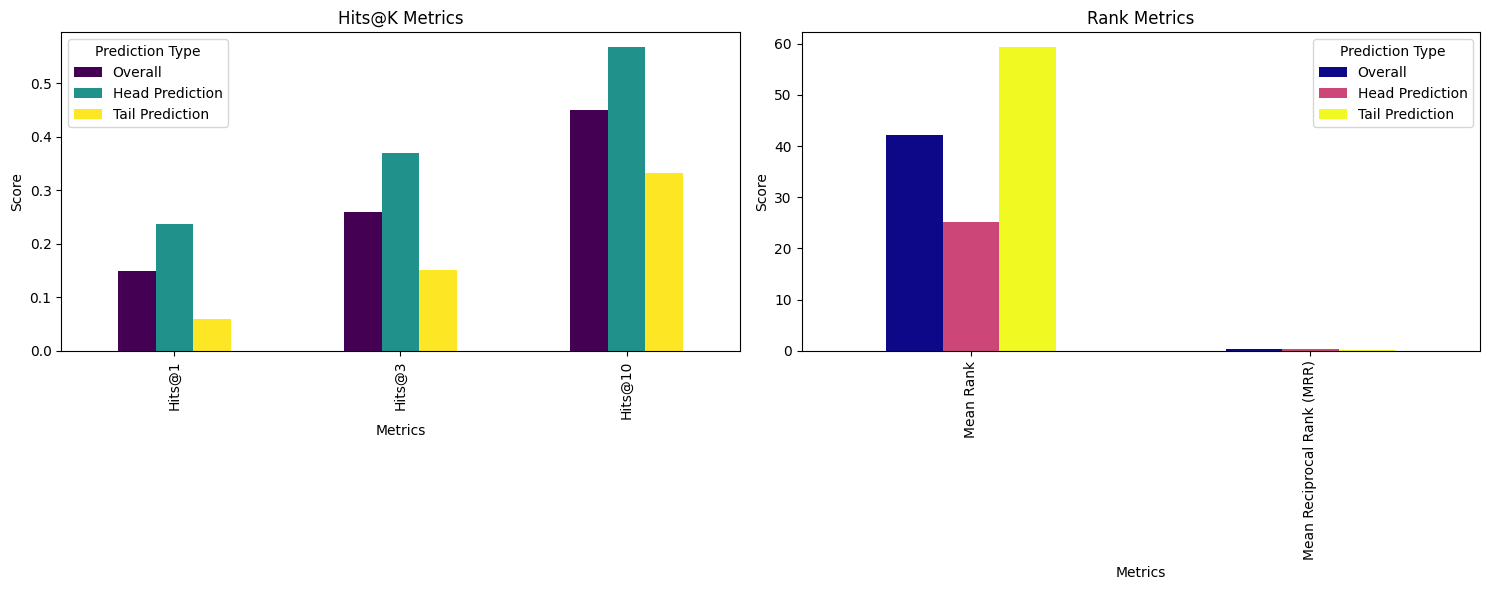

In [120]:
# Plot the metrics
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Bar Plot for Hits@K Metrics
hits_metrics = metrics_df[metrics_df['Metric'].str.startswith("Hits")]
hits_metrics.plot(x="Metric", kind="bar", ax=ax[0], colormap="viridis")
ax[0].set_title("Hits@K Metrics")
ax[0].set_ylabel("Score")
ax[0].set_xlabel("Metrics")
ax[0].legend(title="Prediction Type")

# Bar Plot for Rank Metrics
rank_metrics = metrics_df[~metrics_df['Metric'].str.startswith("Hits")]
rank_metrics.plot(x="Metric", kind="bar", ax=ax[1], colormap="plasma")
ax[1].set_title("Rank Metrics")
ax[1].set_ylabel("Score")
ax[1].set_xlabel("Metrics")
ax[1].legend(title="Prediction Type")

plt.tight_layout()
plt.show()

## Train ComplEx model

In [122]:
complex_result = pipeline(
    model='ComplEx',
    training=training_factory,
    validation=validation_factory,
    testing=testing_factory,
    epochs=10,
    dimensions=128,
    negative_sampler='basic',
    negative_sampler_kwargs={'num_negs_per_pos': 50},  # Increase negatives if needed
    training_kwargs={
        'checkpoint_name': 'complex_checkpoint_updated.pt',  # File to save checkpoints
        'checkpoint_frequency': 3,  # Save every 3 epochs
    },
    random_seed=42,
    evaluator_kwargs={
        'filtered': True
    }
)


INFO:pykeen.pipeline.api:=> no training loop checkpoint file found at '/Users/pratistha99/.data/pykeen/checkpoints/complex_checkpoint_updated.pt'. Creating a new file.
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.training.training_loop:=> no checkpoint found at '/Users/pratistha99/.data/pykeen/checkpoints/complex_checkpoint_updated.pt'. Creating a new file.
Training batches on cpu: 100%|███████████████████████| 655/655 [00:48<00:00, 15.04batch/s]
Training epochs on cpu:  20%|▏| 2/10 [01:33<06:20, 47.54s/epoch, loss=9.94, prev_loss=14.3
Training batches on cpu: 100%|██████████████████████▉| 654/655 [00:45<00:00, 14.29batch/s]
Training epochs on cpu:  30%|▎| 3/10 [02:21<05:34, 47.83s/epoch, loss=6.53, prev_loss=9.94
Training batches on cpu: 100%|██████████████████████▉| 654/655 [00:49<00:00, 12.71batch/s]
Training epochs on cpu:  30%|▎| 3/10 [03:13<05:34, 47.83s/epoch, loss=3.85, prev_loss=6.53INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 4

In [123]:
# Save the model to a directory
output_directory = "trained_complex_model_updated"
complex_result.save_to_directory(output_directory)

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=1998, num_relations=6, create_inverse_triples=False, num_triples=167622) to file:///Users/pratistha99/Desktop/BDMA/CS/subjects/BDRP/trained_complex_model_updated/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /Users/pratistha99/Desktop/BDMA/CS/subjects/BDRP/trained_complex_model_updated


In [124]:
import json
import pandas as pd

# Path to the results JSON file
results_path = "trained_complex_model_updated/results.json"

# Load the results file
with open(results_path, "r") as f:
    results = json.load(f)

# Extract the metrics
metrics = results.get("metrics", {})
realistic = metrics.get("both", {}).get("realistic", {})
head_realistic = metrics.get("head", {}).get("realistic", {})
tail_realistic = metrics.get("tail", {}).get("realistic", {})

# Combine the metrics into a DataFrame for better readability
performance_data = {
    "Metric": [
        "Mean Rank",
        "Mean Reciprocal Rank (MRR)",
        "Hits@1",
        "Hits@3",
        "Hits@10",
    ],
    "Overall": [
        realistic.get("arithmetic_mean_rank", None),
        realistic.get("inverse_harmonic_mean_rank", None),
        realistic.get("hits_at_1", None),
        realistic.get("hits_at_3", None),
        realistic.get("hits_at_10", None),
    ],
    "Head Prediction": [
        head_realistic.get("arithmetic_mean_rank", None),
        head_realistic.get("inverse_harmonic_mean_rank", None),
        head_realistic.get("hits_at_1", None),
        head_realistic.get("hits_at_3", None),
        head_realistic.get("hits_at_10", None),
    ],
    "Tail Prediction": [
        tail_realistic.get("arithmetic_mean_rank", None),
        tail_realistic.get("inverse_harmonic_mean_rank", None),
        tail_realistic.get("hits_at_1", None),
        tail_realistic.get("hits_at_3", None),
        tail_realistic.get("hits_at_10", None),
    ],
}

# Create a DataFrame
metrics_df = pd.DataFrame(performance_data)

# Display the metrics
print("Link Prediction Performance Metrics:")
print(metrics_df)


Link Prediction Performance Metrics:
                       Metric     Overall  Head Prediction  Tail Prediction
0                   Mean Rank  349.686005       370.638062       328.733948
1  Mean Reciprocal Rank (MRR)    0.039750         0.046971         0.032529
2                      Hits@1    0.013127         0.017094         0.009159
3                      Hits@3    0.032058         0.040508         0.023609
4                     Hits@10    0.081322         0.096551         0.066093


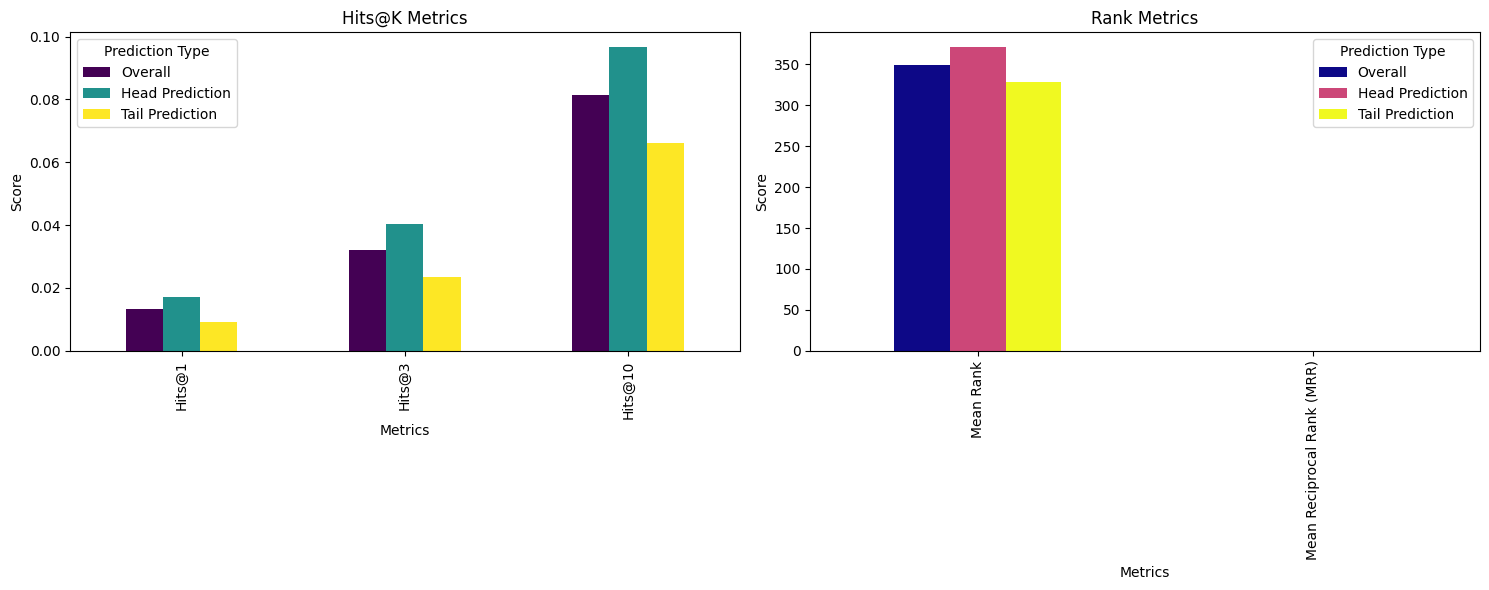

In [125]:
# Plot the metrics
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Bar Plot for Hits@K Metrics
hits_metrics = metrics_df[metrics_df['Metric'].str.startswith("Hits")]
hits_metrics.plot(x="Metric", kind="bar", ax=ax[0], colormap="viridis")
ax[0].set_title("Hits@K Metrics")
ax[0].set_ylabel("Score")
ax[0].set_xlabel("Metrics")
ax[0].legend(title="Prediction Type")

# Bar Plot for Rank Metrics
rank_metrics = metrics_df[~metrics_df['Metric'].str.startswith("Hits")]
rank_metrics.plot(x="Metric", kind="bar", ax=ax[1], colormap="plasma")
ax[1].set_title("Rank Metrics")
ax[1].set_ylabel("Score")
ax[1].set_xlabel("Metrics")
ax[1].legend(title="Prediction Type")

plt.tight_layout()
plt.show()

## Train RotatE model

In [127]:
rotate_result = pipeline(
    model='RotatE',
    training=training_factory,
    validation=validation_factory,
    testing=testing_factory,
    epochs=10,
    dimensions=128,
    negative_sampler='basic',
    negative_sampler_kwargs={'num_negs_per_pos': 50},  # Increase negatives if needed
    training_kwargs={
        'checkpoint_name': 'rotate_checkpoint_updated.pt',  # File to save checkpoints
        'checkpoint_frequency': 3,  # Save every 3 epochs
    },
    random_seed=42,
    evaluator_kwargs={
        'filtered': True
    }
)

INFO:pykeen.pipeline.api:=> no training loop checkpoint file found at '/Users/pratistha99/.data/pykeen/checkpoints/rotate_checkpoint_updated.pt'. Creating a new file.
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.training.training_loop:=> no checkpoint found at '/Users/pratistha99/.data/pykeen/checkpoints/rotate_checkpoint_updated.pt'. Creating a new file.
Training batches on cpu: 100%|███████████████████████| 655/655 [00:20<00:00, 25.03batch/s]
Training epochs on cpu:  10%| | 1/10 [00:22<03:22, 22.51s/epoch, loss=0.614, prev_loss=nan
Training batches on cpu: 100%|██████████████████████▉| 653/655 [00:20<00:00, 31.04batch/s]
Training epochs on cpu:  20%|▏| 2/10 [00:44<02:58, 22.36s/epoch, loss=0.295, prev_loss=0.6
Training batches on cpu: 100%|██████████████████████▉| 654/655 [00:22<00:00, 25.16batch/s]
Training epochs on cpu:  30%|▎| 3/10 [01:09<02:44, 23.47s/epoch, loss=0.228, prev_loss=0.2
Training batches on cpu: 100%|███████████████████████| 655/655 [00:25<00:00, 27.04bat

In [131]:
# Save the model to a directory
output_directory = "trained_rotate_result_updated"
rotate_result.save_to_directory(output_directory)

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=1998, num_relations=6, create_inverse_triples=False, num_triples=167622) to file:///Users/pratistha99/Desktop/BDMA/CS/subjects/BDRP/trained_rotate_result_updated/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /Users/pratistha99/Desktop/BDMA/CS/subjects/BDRP/trained_rotate_result_updated


In [132]:
import json
import pandas as pd

# Path to the results JSON file
results_path = "trained_rotate_result_updated/results.json"

# Load the results file
with open(results_path, "r") as f:
    results = json.load(f)

# Extract the metrics
metrics = results.get("metrics", {})
realistic = metrics.get("both", {}).get("realistic", {})
head_realistic = metrics.get("head", {}).get("realistic", {})
tail_realistic = metrics.get("tail", {}).get("realistic", {})

# Combine the metrics into a DataFrame for better readability
performance_data = {
    "Metric": [
        "Mean Rank",
        "Mean Reciprocal Rank (MRR)",
        "Hits@1",
        "Hits@3",
        "Hits@10",
    ],
    "Overall": [
        realistic.get("arithmetic_mean_rank", None),
        realistic.get("inverse_harmonic_mean_rank", None),
        realistic.get("hits_at_1", None),
        realistic.get("hits_at_3", None),
        realistic.get("hits_at_10", None),
    ],
    "Head Prediction": [
        head_realistic.get("arithmetic_mean_rank", None),
        head_realistic.get("inverse_harmonic_mean_rank", None),
        head_realistic.get("hits_at_1", None),
        head_realistic.get("hits_at_3", None),
        head_realistic.get("hits_at_10", None),
    ],
    "Tail Prediction": [
        tail_realistic.get("arithmetic_mean_rank", None),
        tail_realistic.get("inverse_harmonic_mean_rank", None),
        tail_realistic.get("hits_at_1", None),
        tail_realistic.get("hits_at_3", None),
        tail_realistic.get("hits_at_10", None),
    ],
}

# Create a DataFrame
metrics_df = pd.DataFrame(performance_data)

# Display the metrics
print("Link Prediction Performance Metrics:")
print(metrics_df)


Link Prediction Performance Metrics:
                       Metric    Overall  Head Prediction  Tail Prediction
0                   Mean Rank  25.097191        13.974192        36.220188
1  Mean Reciprocal Rank (MRR)   0.395923         0.474539         0.317306
2                      Hits@1   0.278557         0.352488         0.204627
3                      Hits@3   0.437665         0.522314         0.353017
4                     Hits@10   0.637504         0.727637         0.547370


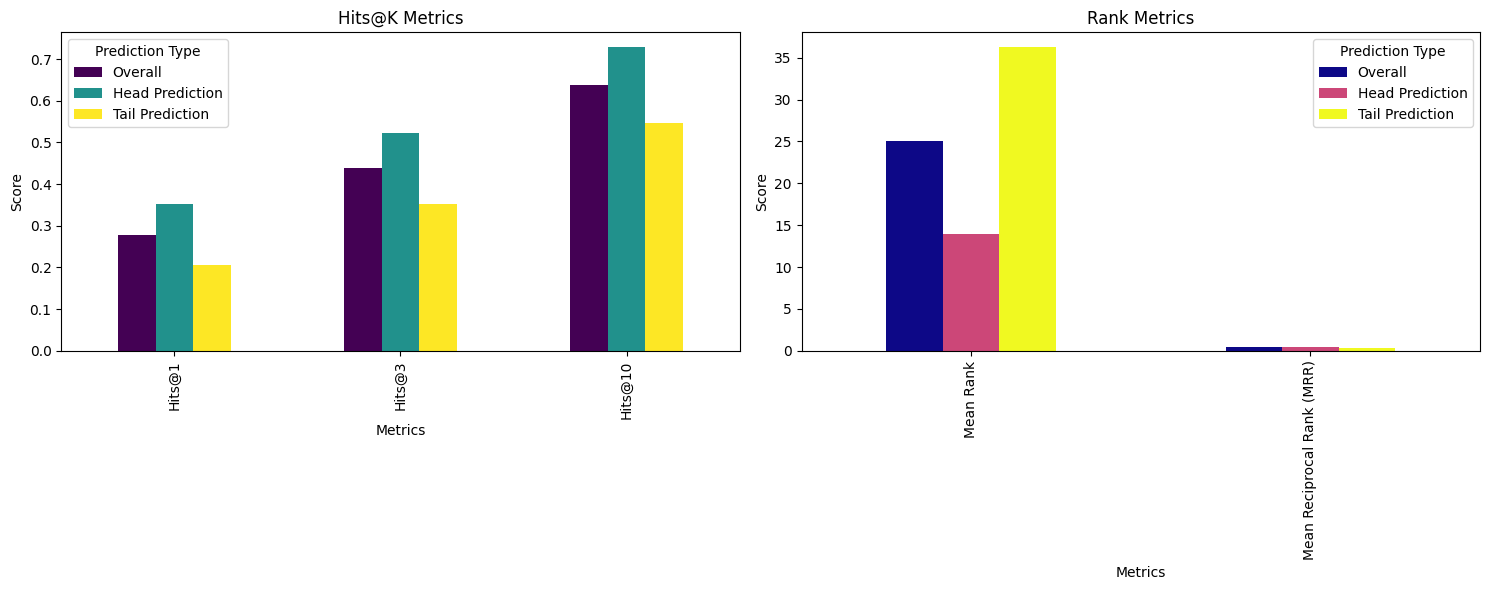

In [133]:
# Plot the metrics
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Bar Plot for Hits@K Metrics
hits_metrics = metrics_df[metrics_df['Metric'].str.startswith("Hits")]
hits_metrics.plot(x="Metric", kind="bar", ax=ax[0], colormap="viridis")
ax[0].set_title("Hits@K Metrics")
ax[0].set_ylabel("Score")
ax[0].set_xlabel("Metrics")
ax[0].legend(title="Prediction Type")

# Bar Plot for Rank Metrics
rank_metrics = metrics_df[~metrics_df['Metric'].str.startswith("Hits")]
rank_metrics.plot(x="Metric", kind="bar", ax=ax[1], colormap="plasma")
ax[1].set_title("Rank Metrics")
ax[1].set_ylabel("Score")
ax[1].set_xlabel("Metrics")
ax[1].legend(title="Prediction Type")

plt.tight_layout()
plt.show()

In [159]:

# Extract embeddings from models
transE_embeddings = transe_result.model.entity_representations[0]().detach().cpu().numpy()
complEx_embeddings = np.concatenate(
    [complex_result.model.entity_representations[0]().real.detach().cpu().numpy(),
     complex_result.model.entity_representations[0]().imag.detach().cpu().numpy()],
    axis=1
)
rotate_embeddings = rotate_result.model.entity_representations[0]().detach().cpu().numpy()

In [160]:
# Convert RotatE complex embeddings to real-valued embeddings
rotate_real_embeddings = np.concatenate(
    [rotate_embeddings.real, rotate_embeddings.imag], axis=1
)

## GCN

In [153]:
import torch
import numpy as np
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Step 1: Define GCN Model
class GCNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Step 2: Prepare the data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Step 3: Initialize the GCN Model
gcn_model = GCNModel(input_dim=128, hidden_dim=64, output_dim=128).to(device)
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

# Step 4: Train the GCN Model
gcn_model.train()
for epoch in range(50):
    optimizer.zero_grad()
    # Set the edge_index for training
    data.edge_index = data.train_pos_edge_index  # Use train edges
    gcn_embeddings = gcn_model(data.x, data.edge_index)
    loss = loss_fn(gcn_embeddings, data.x)  # Reconstruction loss
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/50, Loss: {loss.item():.4f}")

Epoch 1/50, Loss: 1.1546
Epoch 2/50, Loss: 1.0724
Epoch 3/50, Loss: 1.0308
Epoch 4/50, Loss: 1.0012
Epoch 5/50, Loss: 0.9760
Epoch 6/50, Loss: 0.9536
Epoch 7/50, Loss: 0.9343
Epoch 8/50, Loss: 0.9178
Epoch 9/50, Loss: 0.9038
Epoch 10/50, Loss: 0.8920
Epoch 11/50, Loss: 0.8820
Epoch 12/50, Loss: 0.8732
Epoch 13/50, Loss: 0.8652
Epoch 14/50, Loss: 0.8579
Epoch 15/50, Loss: 0.8510
Epoch 16/50, Loss: 0.8447
Epoch 17/50, Loss: 0.8388
Epoch 18/50, Loss: 0.8333
Epoch 19/50, Loss: 0.8283
Epoch 20/50, Loss: 0.8236
Epoch 21/50, Loss: 0.8191
Epoch 22/50, Loss: 0.8148
Epoch 23/50, Loss: 0.8105
Epoch 24/50, Loss: 0.8065
Epoch 25/50, Loss: 0.8028
Epoch 26/50, Loss: 0.7994
Epoch 27/50, Loss: 0.7960
Epoch 28/50, Loss: 0.7926
Epoch 29/50, Loss: 0.7895
Epoch 30/50, Loss: 0.7866
Epoch 31/50, Loss: 0.7838
Epoch 32/50, Loss: 0.7811
Epoch 33/50, Loss: 0.7785
Epoch 34/50, Loss: 0.7760
Epoch 35/50, Loss: 0.7735
Epoch 36/50, Loss: 0.7712
Epoch 37/50, Loss: 0.7690
Epoch 38/50, Loss: 0.7669
Epoch 39/50, Loss: 0.

In [154]:
# Step 5: Evaluate GCN for Link Prediction
def compute_ranking_metrics(embeddings, pos_edge_index):
    """
    Compute Hits@K, Mean Rank (MR), and Mean Reciprocal Rank (MRR) for link prediction.
    """
    ranks = []
    hits_at_1, hits_at_3, hits_at_10 = 0, 0, 0
    
    # Iterate over positive edges
    for i in range(pos_edge_index.size(1)):
        src, dst = pos_edge_index[0, i], pos_edge_index[1, i]
        
        # Compute scores for all nodes (negative samples + positive target)
        scores = (embeddings[src] * embeddings).sum(dim=1)
        sorted_indices = torch.argsort(scores, descending=True)
        
        # Find the rank of the positive target
        rank = (sorted_indices == dst).nonzero(as_tuple=True)[0].item() + 1  # 1-based rank
        ranks.append(rank)
        
        # Update Hits@K counts
        if rank <= 1: hits_at_1 += 1
        if rank <= 3: hits_at_3 += 1
        if rank <= 10: hits_at_10 += 1
    
    # Compute Mean Rank and MRR
    mean_rank = np.mean(ranks)
    mrr = np.mean([1.0 / rank for rank in ranks])
    
    # Compute Hits@K
    hits_at_1 /= len(ranks)
    hits_at_3 /= len(ranks)
    hits_at_10 /= len(ranks)
    
    return mean_rank, mrr, hits_at_1, hits_at_3, hits_at_10


In [155]:
# Step 6: Evaluate on test data
gcn_model.eval()
with torch.no_grad():
    data.edge_index = data.test_pos_edge_index  # Use test edges
    gcn_embeddings = gcn_model(data.x, data.edge_index)

# Compute ranking metrics
mean_rank, mrr, hits_at_1, hits_at_3, hits_at_10 = compute_ranking_metrics(
    gcn_embeddings, data.test_pos_edge_index
)

# Display Results
print("GCN Link Prediction Performance:")
print(f"Mean Rank (MR): {mean_rank:.4f}")
print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")
print(f"Hits@1: {hits_at_1:.4f}")
print(f"Hits@3: {hits_at_3:.4f}")
print(f"Hits@10: {hits_at_10:.4f}")

GCN Link Prediction Performance:
Mean Rank (MR): 92.6881
Mean Reciprocal Rank (MRR): 0.3233
Hits@1: 0.1332
Hits@3: 0.4583
Hits@10: 0.6471


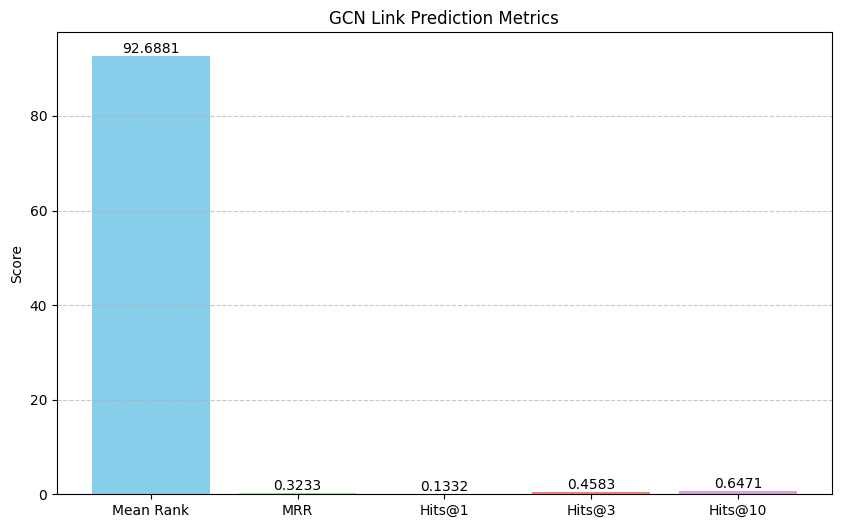

In [156]:
# Step 6: Visualization
metrics = {
    "Mean Rank": mean_rank,
    "MRR": mrr,
    "Hits@1": hits_at_1,
    "Hits@3": hits_at_3,
    "Hits@10": hits_at_10
}

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'lightgreen', 'orange', 'salmon', 'plum'])
plt.title("GCN Link Prediction Metrics")
plt.ylabel("Score")
plt.ylim(0, max(metrics.values()) + 5)  # Adjust Y-axis for better visualization
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Clustering Results

TransE Clustering Metrics:
Silhouette Score: 0.0596
Davies-Bouldin Index: 4.2867
Calinski-Harabasz Index: 88.3281

Cluster 0 contains 280 entities
2     Gene_10024
3     Gene_10048
9     Gene_10112
22    Gene_10199
23      Gene_102
Name: entity, dtype: object
Cluster 1 contains 586 entities
1412         Pathway_0000000
1413    Pathway_R-HSA-109581
1414    Pathway_R-HSA-109582
1415    Pathway_R-HSA-111465
1416    Pathway_R-HSA-111885
Name: entity, dtype: object
Cluster 2 contains 224 entities
0     Gene_10010
7     Gene_10100
11    Gene_10124
13    Gene_10128
44    Gene_10431
Name: entity, dtype: object
Cluster 3 contains 469 entities
4     Gene_10049
10    Gene_10113
12    Gene_10125
15    Gene_10146
16    Gene_10153
Name: entity, dtype: object
Cluster 4 contains 439 entities
1     Gene_10016
5     Gene_10092
6     Gene_10096
8     Gene_10106
14    Gene_10135
Name: entity, dtype: object


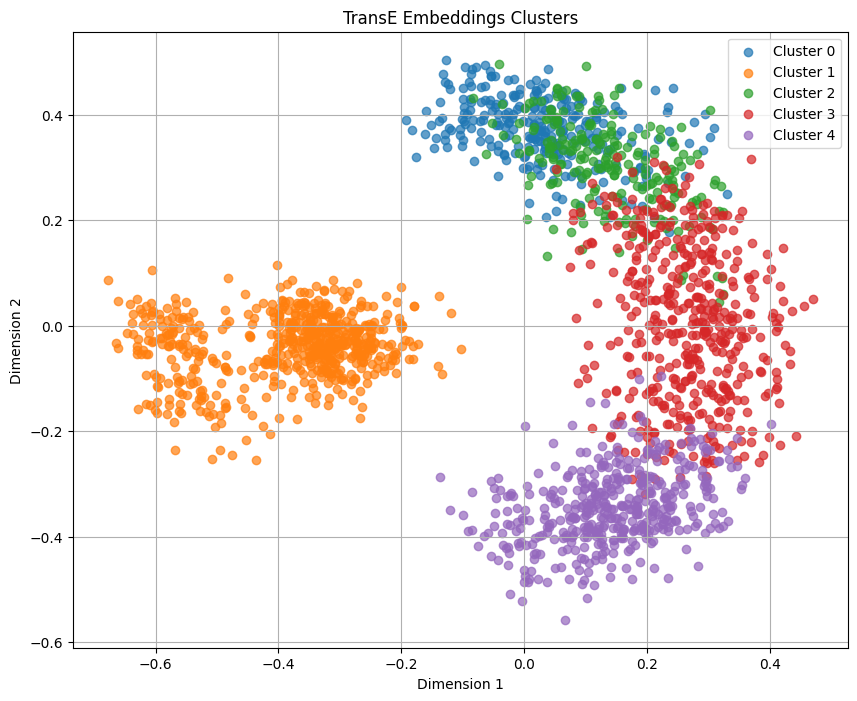

ComplEx Clustering Metrics:
Silhouette Score: -0.0011
Davies-Bouldin Index: 9.2813
Calinski-Harabasz Index: 7.5073

Cluster 0 contains 2 entities
285     Gene_2258
748    Gene_55103
Name: entity, dtype: object
Cluster 1 contains 189 entities
91     Gene_11073
301    Gene_22985
329    Gene_23398
471     Gene_3183
545     Gene_4149
Name: entity, dtype: object
Cluster 2 contains 523 entities
4     Gene_10049
19    Gene_10175
20    Gene_10179
21    Gene_10190
29     Gene_1025
Name: entity, dtype: object
Cluster 3 contains 682 entities
1     Gene_10016
5     Gene_10092
6     Gene_10096
8     Gene_10106
10    Gene_10113
Name: entity, dtype: object
Cluster 4 contains 602 entities
0    Gene_10010
2    Gene_10024
3    Gene_10048
7    Gene_10100
9    Gene_10112
Name: entity, dtype: object


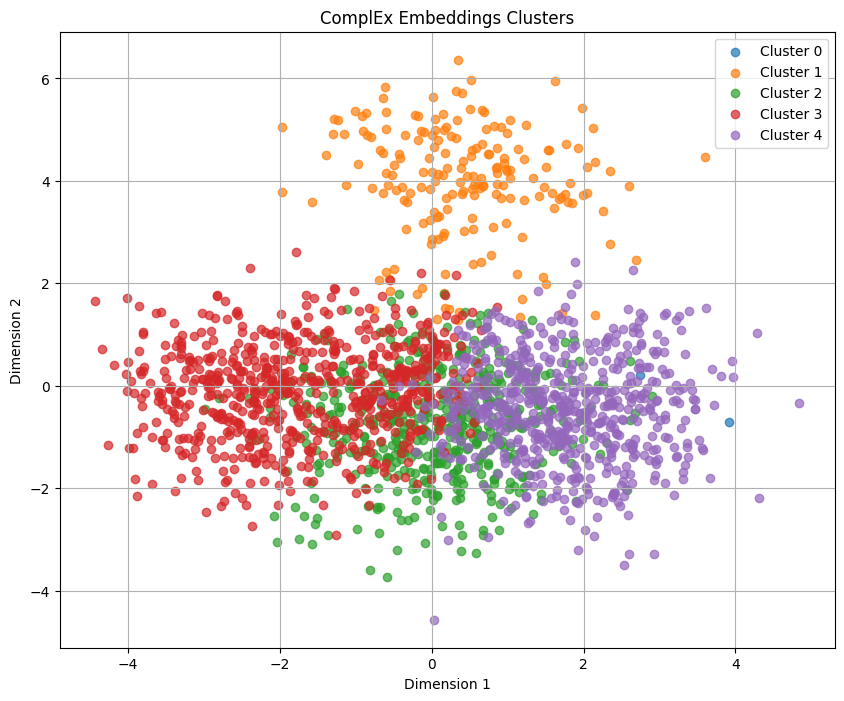

GCN Clustering Metrics:
Silhouette Score: 0.0140
Davies-Bouldin Index: 5.8541
Calinski-Harabasz Index: 24.4194

Cluster 0 contains 480 entities
4     Gene_10049
12    Gene_10125
24    Gene_10210
25    Gene_10235
26    Gene_10237
Name: entity, dtype: object
Cluster 1 contains 379 entities
0     Gene_10010
17    Gene_10154
23      Gene_102
29     Gene_1025
31     Gene_1027
Name: entity, dtype: object
Cluster 2 contains 423 entities
3     Gene_10048
11    Gene_10124
13    Gene_10128
14    Gene_10135
16    Gene_10153
Name: entity, dtype: object
Cluster 3 contains 421 entities
1     Gene_10016
6     Gene_10096
7     Gene_10100
9     Gene_10112
21    Gene_10190
Name: entity, dtype: object
Cluster 4 contains 295 entities
2     Gene_10024
5     Gene_10092
8     Gene_10106
10    Gene_10113
15    Gene_10146
Name: entity, dtype: object


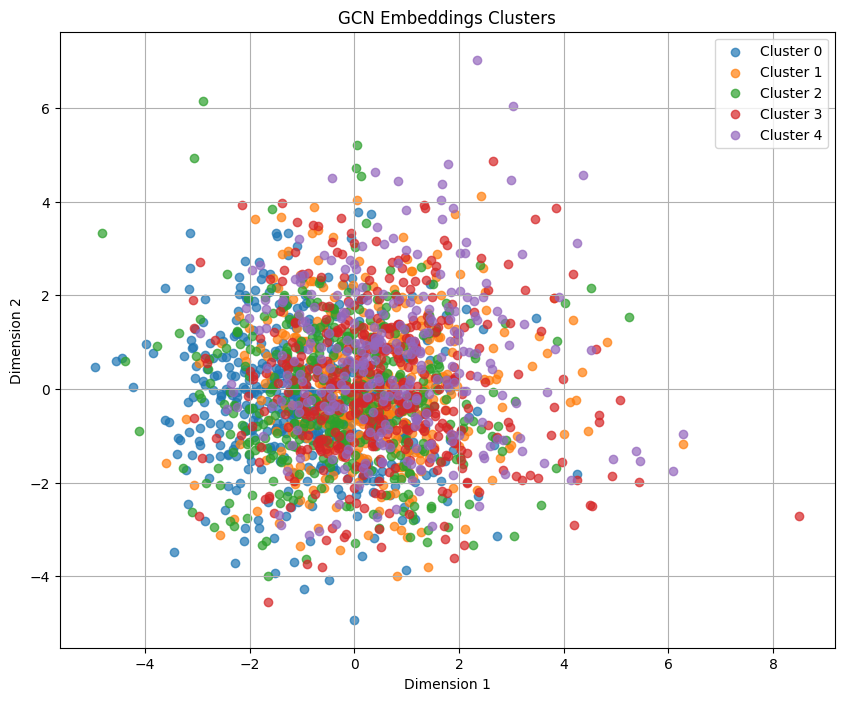

RotatE Clustering Metrics:
Silhouette Score: 0.1367
Davies-Bouldin Index: 2.1654
Calinski-Harabasz Index: 300.8616

Cluster 0 contains 418 entities
2     Gene_10024
3     Gene_10048
7     Gene_10100
9     Gene_10112
11    Gene_10124
Name: entity, dtype: object
Cluster 1 contains 210 entities
4     Gene_10049
15    Gene_10146
16    Gene_10153
17    Gene_10154
19    Gene_10175
Name: entity, dtype: object
Cluster 2 contains 451 entities
0     Gene_10010
10    Gene_10113
12    Gene_10125
13    Gene_10128
20    Gene_10179
Name: entity, dtype: object
Cluster 3 contains 586 entities
1412         Pathway_0000000
1413    Pathway_R-HSA-109581
1414    Pathway_R-HSA-109582
1415    Pathway_R-HSA-111465
1416    Pathway_R-HSA-111885
Name: entity, dtype: object
Cluster 4 contains 333 entities
1     Gene_10016
5     Gene_10092
6     Gene_10096
8     Gene_10106
14    Gene_10135
Name: entity, dtype: object


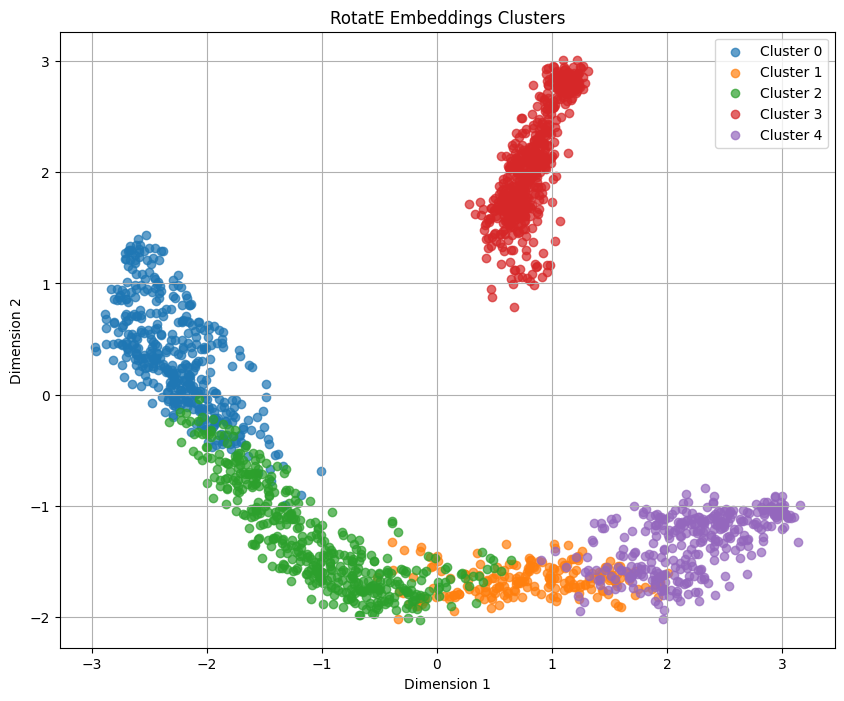

In [161]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def cluster_and_visualize(embeddings, model_name, entities_list):
    """
    Perform KMeans clustering on embeddings, calculate metrics, and visualize clusters.
    
    Args:
        embeddings: numpy array of entity embeddings.
        model_name: str, name of the model for reference.
        entities_list: list of entity names corresponding to the embeddings.
    """
    # Clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)

    # Calculate Clustering Metrics
    silhouette = silhouette_score(embeddings, cluster_labels)
    db_index = davies_bouldin_score(embeddings, cluster_labels)
    ch_index = calinski_harabasz_score(embeddings, cluster_labels)

    print(f"{model_name} Clustering Metrics:")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Index: {db_index:.4f}")
    print(f"Calinski-Harabasz Index: {ch_index:.4f}\n")

    # Create a DataFrame linking entities and cluster assignments
    clusters_df = pd.DataFrame({'entity': entities_list, 'cluster': cluster_labels})

    # Print cluster contents summary
    for cluster_id in np.unique(cluster_labels):
        cluster_entities = clusters_df[clusters_df['cluster'] == cluster_id]['entity']
        print(f"Cluster {cluster_id} contains {len(cluster_entities)} entities")
        print(cluster_entities.head())  # Display a sample of entities in the cluster

    # Dimensionality Reduction (PCA)
    reduced_embeddings = PCA(n_components=2).fit_transform(embeddings)

    # Visualization
    plt.figure(figsize=(10, 8))
    for cluster_id in np.unique(cluster_labels):
        cluster_points = reduced_embeddings[cluster_labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", alpha=0.7)
    plt.title(f"{model_name} Embeddings Clusters")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.grid()
    plt.show()

# Example Usage: Apply clustering and visualization for each embedding type
entities = list(training_factory.entity_to_id.keys())  # List of entity names from the training factory

# Ensure embeddings match the length of entities
assert len(entities) == transE_embeddings.shape[0], "Number of entities and embeddings do not match!"

# Run clustering and visualization
cluster_and_visualize(transE_embeddings, "TransE", entities)
cluster_and_visualize(complEx_embeddings, "ComplEx", entities)
cluster_and_visualize(gcn_embeddings, "GCN", entities)
cluster_and_visualize(rotate_real_embeddings, "RotatE", entities)
